In [99]:
#This needs to be organized
import os.path
import zipfile
import subprocess
import io

import nltk
import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer

from nltk.tag import StanfordNERTagger
from nltk.tag import StanfordPOSTagger
from nltk.parse import stanford
from nltk.tokenize import word_tokenize
from nltk.tree import Tree
from nltk.draw.tree import TreeView
from nltk.tokenize import sent_tokenize

import graphviz
import re

import IPython.display
import tempfile

%matplotlib inline

To using the [Stanford NLP group](http://nlp.stanford.edu/) programs with nltk requires a bit of setup. We are basing these instructions on those provided by nltk, [here](https://github.com/nltk/nltk/wiki/Installing-Third-Party-Software#stanford-tagger-ner-tokenizer-and-parser), but with a couple of changes for the notebooks.

1. Install [Java 1.8+](http://www.oracle.com/technetwork/java/javase/downloads/jdk8-downloads-2133151.html)
    + Make sure your `JAVAPATH` is setup if you're on windows
2. Download the following zip files from the Stanford NLP group, where DATE is the release date of the files, this will be the value of `stanfordVersion`
    + [`stanford-corenlp-full-2016-10-31.zip`](https://stanfordnlp.github.io/CoreNLP/)
    + [`stanford-postagger-full-DATE.zip`](http://nlp.stanford.edu/software/tagger.html#Download)
    + [`stanford-ner-DATE.zip`](http://nlp.stanford.edu/software/CRF-NER.html#Download)
    + [`stanford-parser-full-DATE.zip`](http://nlp.stanford.edu/software/lex-parser.html#Download)
3. Unzip the files and place the resulting directories in the same location, this will become `stanfordDir`
4. Lookup the version number used by the parser `stanford-parser-VERSION-models.jar` and set to to be `parserVersion`

In [195]:
#This is the date at the end of each of the zip files, e.g.
#the date in stanford-ner-2016-10-31.zip
stanfordVersion = '2016-10-31'

#This is the version numbers of the parser models, these
#are files in `stanford-parser-full-2016-10-31.zip`, e.g.
#stanford-parser-3.7.0-models.jar
parserVersion = '3.7.0'

#This is where the zip files were unzipped.Make sure to
#unzip into directories named after the zip files
#Don't just put all the files in `stanford-NLP`
stanfordDir = '/mnt/efs/resources/shared/stanford-NLP'

#Parser model, there are a few for english and a couple of other languages as well
modelName = 'englishPCFG.ser.gz'

We now will initialize all the tools

Setting up [NER tagger](http://www.nltk.org/api/nltk.tag.html?highlight=stanfordpostagger#nltk.tag.stanford.StanfordNERTagger)

In [21]:
nerClassifierPath = os.path.join(stanfordDir,'stanford-ner-{}'.format(stanfordVersion), 'classifiers/english.all.3class.distsim.crf.ser.gz')

nerJarPath = os.path.join(stanfordDir,'stanford-ner-{}'.format(stanfordVersion), 'stanford-ner.jar')

nerTagger = StanfordNERTagger(nerClassifierPath, nerJarPath)

setting up [POS Tagger](http://www.nltk.org/api/nltk.tag.html?highlight=stanfordpostagger#nltk.tag.stanford.StanfordPOSTagger)

In [22]:
postClassifierPath = os.path.join(stanfordDir, 'stanford-postagger-full-{}'.format(stanfordVersion), 'models/english-bidirectional-distsim.tagger')

postJarPath = os.path.join(stanfordDir,'stanford-postagger-full-{}'.format(stanfordVersion), 'stanford-postagger.jar')

postTagger = StanfordPOSTagger(postClassifierPath, postJarPath)

Setting up [Parser](http://www.nltk.org/api/nltk.parse.html?highlight=stanfordparser#module-nltk.parse.stanford)

In [23]:
parserJarPath = os.path.join(stanfordDir, 'stanford-parser-full-{}'.format(stanfordVersion), 'stanford-parser.jar')

parserModelsPath = os.path.join(stanfordDir, 'stanford-parser-full-{}'.format(stanfordVersion), 'stanford-parser-{}-models.jar'.format(parserVersion))

modelPath = os.path.join(stanfordDir, 'stanford-parser-full-{}'.format(stanfordVersion), modelName)

#The model files are stored in the jar, we need to extract them for nltk to use
if not os.path.isfile(modelPath):
    with zipfile.ZipFile(parserModelsPath) as zf:
        with open(modelPath, 'wb') as f:
            f.write(zf.read('edu/stanford/nlp/models/lexparser/{}'.format(modelName)))

parser = stanford.StanfordParser(parserJarPath, parserModelsPath, modelPath)

depParser = stanford.StanfordDependencyParser(parserJarPath, parserModelsPath)

Information extraction, this isn't yet supported by nltk so we will be defining our own function. `openIE()` takes in a string or list of strings and produces all the subject, verb, object triples stanford corenlp can find, as a DataFrame.

In [86]:
#Watch out, this will very rarely raise an error since it trusts stanford-corenlp 
def openIE(target):
    if isinstance(target, list):
        target = '\n'.join(target)
    #setup the java targets
    coreDir = '{}/stanford-corenlp-full-{}'.format(stanfordDir, stanfordVersion)
    cp = '{0}/stanford-corenlp-{1}.jar:{0}/stanford-corenlp-{1}-models.jar:CoreNLP-to-HTML.xsl:slf4j-api.jar:slf4j-simple.jar'.format(coreDir, parserVersion)
    with tempfile.NamedTemporaryFile(mode = 'w', delete = False) as f:
        #Core nlp requires a files, so we will make a temp one to pass to it
        #This file should be deleted by the OS soon after it has been used
        f.write(target)
        f.seek(0)
        print("Starting OpenIE run")
        sp = subprocess.run(['java', '-mx2g', '-cp', cp, 'edu.stanford.nlp.naturalli.OpenIE', '-threads', '1', f.name], stdout = subprocess.PIPE, stderr = subprocess.PIPE)
        #Live stderr is non-trivial so this is the best we can do
        print(sp.stderr.decode('utf-8'))
        retSting = sp.stdout.decode('utf-8')
    #Making the DataFrame, again having to pass a fake file, yay POSIX I guess
    with io.StringIO(retSting) as f:
        df = pandas.read_csv(f, delimiter = '\t', names =['certainty', 'subject', 'verb', 'object'])
    return df

Now lets test these tools on a short example

In [30]:
text = ['I saw the elephant in my pajamas.', 'The quick brown fox jumped over the lazy dog.', 'While in France, Christine Lagarde discussed short-term stimulus efforts in a recent interview with the Wall Street Journal.', 'Buffalo buffalo Buffalo buffalo buffalo buffalo Buffalo buffalo']
tokenized_text = [word_tokenize(t) for t in text]
print('\n'.join(text))

I saw the elephant in my pajamas.
The quick brown fox jumped over the lazy dog.
While in France, Christine Lagarde discussed short-term stimulus efforts in a recent interview with the Wall Street Journal.
Buffalo buffalo Buffalo buffalo buffalo buffalo Buffalo buffalo


POS tagging

In [33]:
pos_sents = postTagger.tag_sents(tokenized_text)
print(posSents)

[[('I', 'PRP'), ('saw', 'VBD'), ('the', 'DT'), ('elephant', 'NN'), ('in', 'IN'), ('my', 'PRP$'), ('pajamas', 'NNS'), ('.', '.')], [('The', 'DT'), ('quick', 'JJ'), ('brown', 'JJ'), ('fox', 'NN'), ('jumped', 'VBD'), ('over', 'IN'), ('the', 'DT'), ('lazy', 'JJ'), ('dog', 'NN'), ('.', '.')], [('While', 'IN'), ('in', 'IN'), ('France', 'NNP'), (',', ','), ('Christine', 'NNP'), ('Lagarde', 'NNP'), ('discussed', 'VBD'), ('short-term', 'JJ'), ('stimulus', 'NN'), ('efforts', 'NNS'), ('in', 'IN'), ('a', 'DT'), ('recent', 'JJ'), ('interview', 'NN'), ('with', 'IN'), ('the', 'DT'), ('Wall', 'NNP'), ('Street', 'NNP'), ('Journal', 'NNP'), ('.', '.')], [('Buffalo', 'NNP'), ('buffalo', 'NN'), ('Buffalo', 'NNP'), ('buffalo', 'NN'), ('buffalo', 'NN'), ('buffalo', 'NN'), ('Buffalo', 'NNP'), ('buffalo', 'NN')]]


Named-Entity Recognition

In [34]:
classified_sents = nerTagger.tag_sents(tokenized_text)
print(classified_text)

[[('I', 'O'), ('saw', 'O'), ('the', 'O'), ('elephant', 'O'), ('in', 'O'), ('my', 'O'), ('pajamas', 'O'), ('.', 'O')], [('The', 'O'), ('quick', 'O'), ('brown', 'O'), ('fox', 'O'), ('jumped', 'O'), ('over', 'O'), ('the', 'O'), ('lazy', 'O'), ('dog', 'O'), ('.', 'O')], [('While', 'O'), ('in', 'O'), ('France', 'LOCATION'), (',', 'O'), ('Christine', 'PERSON'), ('Lagarde', 'PERSON'), ('discussed', 'O'), ('short-term', 'O'), ('stimulus', 'O'), ('efforts', 'O'), ('in', 'O'), ('a', 'O'), ('recent', 'O'), ('interview', 'O'), ('with', 'O'), ('the', 'O'), ('Wall', 'ORGANIZATION'), ('Street', 'ORGANIZATION'), ('Journal', 'ORGANIZATION'), ('.', 'O')], [('Buffalo', 'LOCATION'), ('buffalo', 'O'), ('Buffalo', 'ORGANIZATION'), ('buffalo', 'O'), ('buffalo', 'O'), ('buffalo', 'O'), ('Buffalo', 'ORGANIZATION'), ('buffalo', 'O')]]


Non-Dependency Parsing

In [82]:
parses = list(parser.parse_sents(tokenized_text)) #Converting the iterator to a list so we can call by index. They are still 
fistSentParseTree = list(parses[0]) #iterators so be careful about re-running code, without re-running this block
print(fistSentParseTree)

[Tree('ROOT', [Tree('S', [Tree('NP', [Tree('PRP', ['I'])]), Tree('VP', [Tree('VBD', ['saw']), Tree('NP', [Tree('DT', ['the']), Tree('NN', ['elephant'])]), Tree('PP', [Tree('IN', ['in']), Tree('NP', [Tree('PRP$', ['my']), Tree('NNS', ['pajamas'])])])]), Tree('.', ['.'])])])]


Or if we want the tree looking a bit nicer

In [57]:
fistSentParseTree[0].pretty_print()

                  ROOT                           
                   |                              
                   S                             
  _________________|___________________________   
 |                 VP                          | 
 |    _____________|__________                 |  
 |   |       |                PP               | 
 |   |       |             ___|____            |  
 NP  |       NP           |        NP          | 
 |   |    ___|_____       |    ____|_____      |  
PRP VBD  DT        NN     IN PRP$       NNS    . 
 |   |   |         |      |   |          |     |  
 I  saw the     elephant  in  my      pajamas  . 



Or another sentence

In [58]:
list(parses[3])[0].pretty_print()

                          ROOT                                     
                           |                                        
                           NP                                      
            _______________|_____________________________           
           NP                      NP                    NP        
    _______|_______         _______|_______         _____|_____     
  NNP     NNP     NNP      JJ      JJ      NN     NNP         NNP  
   |       |       |       |       |       |       |           |    
Buffalo buffalo Buffalo buffalo buffalo buffalo Buffalo     buffalo



Dependency Parsing

We can also work on the un tokenized text

In [78]:
depParses = list(depParser.raw_parse_sents(text)) #Converting the iterator to a list so we can call by index. They are still 
secondSentDepParseTree = list(depParses[1])[0] #iterators so be careful about re-running code, without re-running this block
print(secondSentDepParseTree)

defaultdict(<function DependencyGraph.__init__.<locals>.<lambda> at 0x111aaaea0>,
            {0: {'address': 0,
                 'ctag': 'TOP',
                 'deps': defaultdict(<class 'list'>, {'root': [5]}),
                 'feats': None,
                 'head': None,
                 'lemma': None,
                 'rel': None,
                 'tag': 'TOP',
                 'word': None},
             1: {'address': 1,
                 'ctag': 'DT',
                 'deps': defaultdict(<class 'list'>, {}),
                 'feats': '_',
                 'head': 4,
                 'lemma': '_',
                 'rel': 'det',
                 'tag': 'DT',
                 'word': 'The'},
             2: {'address': 2,
                 'ctag': 'JJ',
                 'deps': defaultdict(<class 'list'>, {}),
                 'feats': '_',
                 'head': 4,
                 'lemma': '_',
                 'rel': 'amod',
                 'tag': 'JJ',
                 'word

This is a graph and we can convert it to a dot file and use that to visulize it. 

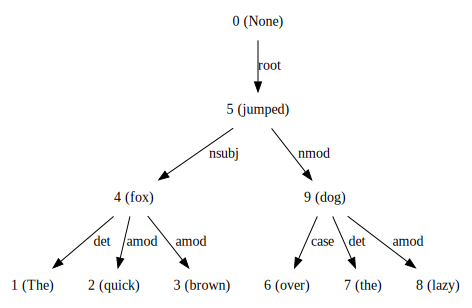

In [79]:
secondSentGraph = graphviz.Source(secondSentDepParseTree.to_dot())
secondSentGraph

Or another sentence 

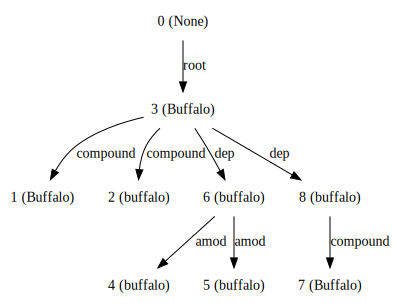

In [80]:
graphviz.Source(list(depParses[3])[0].to_dot())

Information extraction

In [88]:
ieDF = openIE(text)

Starting OpenIE run
Adding annotator tokenize
Adding annotator ssplit
Adding annotator pos
Loading POS tagger from edu/stanford/nlp/models/pos-tagger/english-left3words/english-left3words-distsim.tagger ... done [0.6 sec].
Adding annotator lemma
Adding annotator depparse
Loading depparse model file: edu/stanford/nlp/models/parser/nndep/english_UD.gz ... 
PreComputed 99996, Elapsed Time: 12.354 (s)
Initializing dependency parser ... done [13.6 sec].
Adding annotator natlog
Adding annotator openie
Loading clause splitter from edu/stanford/nlp/models/naturalli/clauseSearcherModel.ser.gz ... done [0.0064 seconds]
Processing file: /var/folders/lk/cq97m8gs5_z62sdfszp2x9jw0000gn/T/tmp9gvi3y24
All files have been queued; awaiting termination...
DONE processing files. 0 exceptions encountered.



`openIE()` prints everything stanford core produces and we can see from looking at it that initializing the dependency parser takes most of the time, so calling the function will always take atleast 12 seconds.

In [89]:
ieDF

,certainty,subject,verb,object
0,1.0,elephant,is in,my pajamas
1,1.0,I,saw,elephant in my pajamas
2,1.0,I,saw,elephant
3,1.0,quick brown fox,jumped over,lazy dog
4,1.0,quick brown fox,jumped over,dog
5,1.0,quick fox,jumped over,dog
6,1.0,fox,jumped over,dog
7,1.0,brown fox,jumped over,lazy dog
8,1.0,brown fox,jumped over,dog
9,1.0,quick fox,jumped over,lazy dog


No buffalos, but the rest looks good 

Lets try with a bigger corpus. We will look at a few of the top posts from the reddit data we used last week

In [111]:
redditDF = pandas.read_csv('data/reddit.csv')

Grabbing the 10 highest scoring posts and tokenizing the sentences. Notice, we aren't going to do any kind of stemming this week.

In [141]:
redditTopScores = redditDF.sort_values('score')[-10:]
redditTopScores['sentences'] = redditTopScores['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
redditTopScores.index = range(len(redditTopScores) - 1, -1,-1) #Reindex to make things nice in the future
redditTopScores

,Unnamed: 0,author,over_18,score,subreddit,text,title,url,sentences
9,8,brenkelieshere,False,9448,Tales From Tech Support,"Last year, Help Desk got a call from a user co...",How to fix a laptop that won't boot in under a...,https://www.reddit.com/r/talesfromtechsupport/...,"[[Last, year, ,, Help, Desk, got, a, call, fro..."
8,7,Bombadils,False,10528,Tales From Tech Support,First post in quite some time! I work at a loc...,"OK, now the password is 'D35p41r'",https://www.reddit.com/r/talesfromtechsupport/...,"[[First, post, in, quite, some, time, !], [I, ..."
7,1200,whenlifegivesyoushit,False,11003,Relationships,[Original Post](https://www.reddit.com/r/relat...,[UPDATE]My [26 F] with my husband [29 M] 1 yea...,https://www.reddit.com/r/relationships/comment...,"[[[, Original, Post, ], (, https, :, //www.red..."
6,6,sfsdfd,False,11295,Tales From Tech Support,I witnessed this astounding IT meltdown around...,"Company-wide email + 30,000 employees + auto-r...",https://www.reddit.com/r/talesfromtechsupport/...,"[[I, witnessed, this, astounding, IT, meltdown..."
5,5,Raitaro,False,12372,Tales From Tech Support,I work Helpdesk for a retail store chain in th...,I'm pretty sure I knocked a user out from near...,https://www.reddit.com/r/talesfromtechsupport/...,"[[I, work, Helpdesk, for, a, retail, store, ch..."
4,4,goldie-gold,False,12650,Tales From Tech Support,"This just happened... So, I had a laptop syst...",Engineer is doing drugs!! No. No they aren't.,https://www.reddit.com/r/talesfromtechsupport/...,"[[This, just, happened, ...], [So, ,, I, had, ..."
3,3,TheDroolinFool,False,13152,Tales From Tech Support,Another tale from the out of hours IT desk... ...,"""I need you to fix Google Bing immediately!""",https://www.reddit.com/r/talesfromtechsupport/...,"[[Another, tale, from, the, out, of, hours, IT..."
2,2,Clickity_clickity,False,13404,Tales From Tech Support,[Part 1](http://www.reddit.com/r/talesfromtech...,"Jack, the Worst End User, Part 4",https://www.reddit.com/r/talesfromtechsupport/...,"[[[, Part, 1, ], (, http, :, //www.reddit.com/..."
1,1,SECGaz,False,13724,Tales From Tech Support,"> $Me - Hello, IT. > $Usr - Hi, I am still ...","Hi, I am still off sick but I am not.",https://www.reddit.com/r/talesfromtechsupport/...,"[[>, $, Me, -, Hello, ,, IT, .], [>, $, Usr, -..."
0,0,guitarsdontdance,False,14089,Tales From Tech Support,So my story starts on what was a normal day ta...,"""Don't bother sending a tech, I'll be dead by ...",https://www.reddit.com/r/talesfromtechsupport/...,"[[So, my, story, starts, on, what, was, a, nor..."


We can do a depency parse

In [142]:
topPostDepParse = list(depParser.parse_sents(redditTopScores['sentences'][0]))

This takes a few seconds, but now lets look at the parse tree of one of the sentences

The sentence is

In [146]:
targetSentence = 7
print(' '.join(redditTopScores['sentences'][0][targetSentence]))

So anyway , I get a call from an older gentleman who 's quite bitter and mean right off the bat ( does n't like that I asked for his address / telephone number to verify the account , hates that he has to speak with a machine before reaching an agent , etc . ) .


Which leads to a very rich dependancy tree

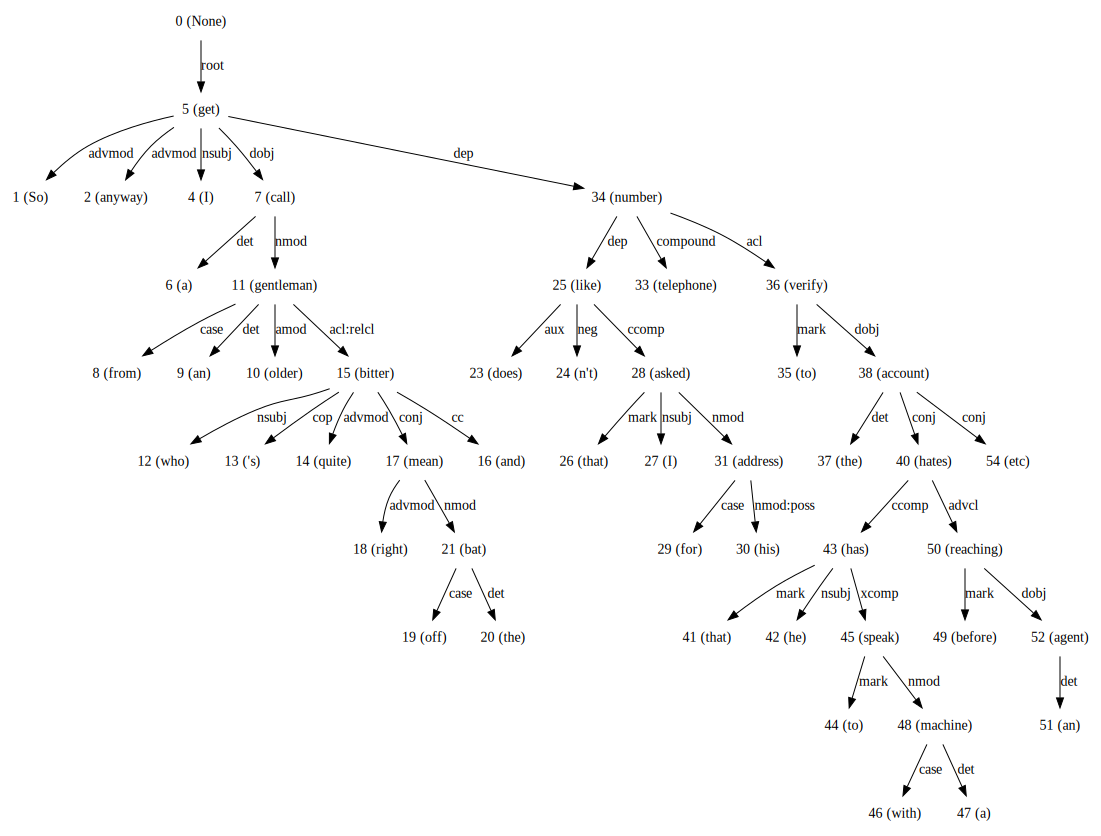

In [144]:
graphviz.Source(list(topPostDepParse[targetSentence])[0].to_dot())

We can run NER over our entire corpus

In [147]:
redditTopScores['classified_sents'] = redditTopScores['sentences'].apply(lambda x: nerTagger.tag_sents(x))

In [148]:
redditTopScores['classified_sents']

9    [[(Last, O), (year, O), (,, O), (Help, O), (De...
8    [[(First, O), (post, O), (in, O), (quite, O), ...
7    [[([, O), (Original, O), (Post, O), (], O), ((...
6    [[(I, O), (witnessed, O), (this, O), (astoundi...
5    [[(I, O), (work, O), (Helpdesk, ORGANIZATION),...
4    [[(This, O), (just, O), (happened, O), (..., O...
3    [[(Another, O), (tale, O), (from, O), (the, O)...
2    [[([, O), (Part, O), (1, O), (], O), ((, O), (...
1    [[(>, O), ($, O), (Me, O), (-, O), (Hello, O),...
0    [[(So, O), (my, O), (story, O), (starts, O), (...
Name: classified_sents, dtype: object

Find the most common

In [160]:
entityCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:10]

[('.', 401),
 ('I', 245),
 ('the', 226),
 (',', 205),
 ('to', 197),
 ('a', 143),
 ('and', 135),
 ('>', 106),
 ('you', 102),
 ('of', 97)]

Or the most common non-objects

In [163]:
nonObjCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'O':
                continue
            elif ent in nonObjCounts:
                nonObjCounts[ent] += 1
            else:
                nonObjCounts[ent] = 1
sortedNonObj = sorted(nonObjCounts.items(), key = lambda x: x[1], reverse = True)
sortedNonObj[:10]

[('Jack', 17),
 ('Google', 6),
 ('Smith', 5),
 ('Steve', 2),
 ('CMD', 1),
 ('Citrix', 1),
 ('GOOGLE', 1),
 ('Spotify', 1),
 ('Helpdesk', 1),
 ('UK', 1)]

These have much smaller counts

We can also do POS

In [164]:
redditTopScores['POS_sents'] = redditTopScores['sentences'].apply(lambda x: postTagger.tag_sents(x))

In [165]:
redditTopScores['POS_sents']

9    [[(Last, JJ), (year, NN), (,, ,), (Help, NN), ...
8    [[(First, JJ), (post, NN), (in, IN), (quite, R...
7    [[([, NNP), (Original, NNP), (Post, NNP), (], ...
6    [[(I, PRP), (witnessed, VBD), (this, DT), (ast...
5    [[(I, PRP), (work, VBP), (Helpdesk, NNP), (for...
4    [[(This, DT), (just, RB), (happened, VBN), (.....
3    [[(Another, DT), (tale, NN), (from, IN), (the,...
2    [[([, NNP), (Part, NNP), (1, CD), (], FW), ((,...
1    [[(>, JJR), ($, $), (Me, PRP), (-, :), (Hello,...
0    [[(So, RB), (my, PRP$), (story, NN), (starts, ...
Name: POS_sents, dtype: object

And count the number of `NN` (nouns)

In [170]:
countTarget = 'NN'
targetCounts = {}
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:10]

[('password', 21),
 ('(', 19),
 (')', 14),
 ('time', 14),
 ('computer', 12),
 ('lot', 12),
 ('life', 11),
 ('email', 11),
 ('**Genius**', 10),
 ('message', 9)]

Notice the top nouns are not the same as the top entities

And we can also look for subject, object, target triples in one of the stories

In [173]:
ieDF = openIE(redditTopScores['text'][0])

Starting OpenIE run
Adding annotator tokenize
Adding annotator ssplit
Adding annotator pos
Loading POS tagger from edu/stanford/nlp/models/pos-tagger/english-left3words/english-left3words-distsim.tagger ... done [0.6 sec].
Adding annotator lemma
Adding annotator depparse
Loading depparse model file: edu/stanford/nlp/models/parser/nndep/english_UD.gz ... 
PreComputed 99996, Elapsed Time: 12.38 (s)
Initializing dependency parser ... done [13.7 sec].
Adding annotator natlog
Adding annotator openie
Loading clause splitter from edu/stanford/nlp/models/naturalli/clauseSearcherModel.ser.gz ... done [0.0887 seconds]
Processing file: /var/folders/lk/cq97m8gs5_z62sdfszp2x9jw0000gn/T/tmpikia6d3v
All files have been queued; awaiting termination...
DONE processing files. 0 exceptions encountered.



In [174]:
ieDF

,certainty,subject,verb,object
0,1.000000,we,'ll get,calls
1,1.000000,we,Quite often 'll get,calls
2,1.000000,we,often 'll get,calls
3,0.831036,we,coax,direct to TV
4,0.774359,straight analog cable,coax,direct from wall
5,0.774359,analog cable,coax,direct from wall to TV
6,0.774359,straight analog cable,coax,direct to TV
7,1.000000,we,would supply analog cable to,homes
8,0.831036,we,coax,direct from wall
9,0.774359,analog cable,coax,direct from wall


That's almost 200 triples in only:

In [175]:
len(redditTopScores['sentences'][0])

37

sentences and

In [180]:
sum([len(s) for s in redditTopScores['sentences'][0]])

971

words.

Lets find at the most common subject

In [192]:
ieDF['subject'].value_counts()

I                        48
it                       42
he                       19
He                       18
we                       11
old man                   8
man                       8
straight analog cable     4
analog cable              4
our booking calendar      4
call                      4
letter                    4
my supervisor             3
his TV set                2
you                       2
they                      2
TV                        2
handling                  1
our equipment             1
our digital equipment     1
people                    1
repeat offenders          1
me                        1
Name: subject, dtype: int64

'I' occures most often with the following verbs

In [193]:
ieDF[ieDF['subject'] == 'I']['verb'].value_counts()

could come                        8
even brought                      5
brought                           5
was                               4
had                               4
speak for                         3
've dealt with                    1
eventually had                    1
ask                               1
think about                       1
took                              1
complaint in                      1
have                              1
instantly felt                    1
get to                            1
still think occasionally about    1
get                               1
speak with                        1
do                                1
So anyway get                     1
think occasionally about          1
felt                              1
still think about                 1
anyway get                        1
had cable within                  1
Name: verb, dtype: int64

and the following objects

In [194]:
ieDF[ieDF['subject'] == 'I']['object'].value_counts()

Mr. Smith                                             4
call                                                  3
him                                                   3
remote                                                2
bad                                                   2
simplified remote for his set top box                 2
this                                                  2
get                                                   2
willing                                               2
simplified remote                                     2
remote for his set top box                            2
bit                                                   1
book                                                  1
residence                                             1
her                                                   1
speak for bit                                         1
speak for bit about account                           1
bit about account for Mr. Smith                 